<a href="https://colab.research.google.com/github/KaRtHiK-56/Machine-Learning-Projects/blob/main/Anamolydetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**ANAMOLY DETECTION USING TIME SERIES DATA**
This will be a python notebook exploring Anomaly Detection. This usecase initially, use just one algorithm (Isolation Forest) to detect the anamolies in the dataset.

In this case study I will discuss the step by step approach to create a Machine Learning predictive model in such scenarios. You can use this flow as a template to solve any Unsupervised Machine learning anamoly detection.

The flow of the case study is as below:

Reading the data in python

Defining the problem statement

Identifying the Target

Looking at the distribution of variables

Basic Data exploration

Rejecting useless columns

Visual Exploratory Data Analysis for data distribution

Missing Values treatment

Visual correlation analysis

Statistical correlation analysis (Feature Selection)

Converting data to numeric for ML

Creating ML Model

Deploying the best model in production

##Importing necessary libraries


In [215]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

##Reading the data

In [216]:
data = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv')
data

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


###Observations
The data set has been successfully imported inside the noteboook.The dataset is basially about the taxi rides(pickups) happened in the city of new york between the time period of 7 mmonths startinf from july of 2014 to january of 2015 selecting the second half of the year and it contains only 2 column which is timestamp	and value, the data has values regularly for a period of 30mins time interval within a day, leaving 48 entries per day.

## Data Description


1.   Timestamp : the date and time of the ride happened
2.   Values : Number of rides that have happened in that particular timestamp




#Defining the Problem statement
Create an anamoly or outlier detection model to effective know about how abnormally the rides have happened in that time period.
The values column is the attribute where the outlier is about to be detected.

#Basic Data Exploration

In [217]:
data.shape

(10320, 2)

In [218]:
data.size

20640

In [219]:
#Statistical summary of the data
data.describe()

,value
count,10320.000000
mean,15137.569380
std,6939.495808
min,8.000000
25%,10262.000000
50%,16778.000000
75%,19838.750000
max,39197.000000


In [220]:
#Information of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  10320 non-null  object
 1   value      10320 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.4+ KB


In [221]:
#converting the timestamp datatype to datetime from object
data['timestamp'] =  pd. to_datetime(data['timestamp'])

In [222]:
data.dtypes

timestamp    datetime64[ns]
value                 int64
dtype: object

In [223]:
#seeing the coluumn names
data.columns

Index(['timestamp', 'value'], dtype='object')

In [224]:
#checking for any repeated values in the data
data.duplicated().sum()

0

In [225]:
#checking for any missing values in the data
data.isnull().sum()

timestamp    0
value        0
dtype: int64

In [226]:
#Seeing the unique values for each column
data.nunique()

timestamp    10320
value         8089
dtype: int64

###Observations of basic data analysis
1. Data has 10320 recorded taxi ride events
2. The average amount of rides that happened per day is	15137.569380
3. Minimum ride that happened in a day was 8 happened in 2014-07-01 00:00:00
4. Maximum ride that happened in a day was 39197 in 2015-01-31 23:30:00
5. Data has no missing values and duplicated values.

#Visual Data Visualisation and Data Distribution

In [227]:
px.line(data,x="timestamp", y="value", title='Taxi rides over the months')

In [228]:
#converting the timestamp column
data = data.set_index('timestamp').resample('H').mean().reset_index()
data

,timestamp,value
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5
...,...,...
5155,2015-01-31 19:00:00,28288.5
5156,2015-01-31 20:00:00,24138.0
5157,2015-01-31 21:00:00,24194.5
5158,2015-01-31 22:00:00,26515.0


In [229]:
px.line(data,x="timestamp", y="value", title='Taxi rides over the months after resampling')

In [230]:
#splitting timestamp column
data['hour'] = data.timestamp.dt.hour
data

,timestamp,value,hour
0,2014-07-01 00:00:00,9485.5,0
1,2014-07-01 01:00:00,5433.0,1
2,2014-07-01 02:00:00,3346.5,2
3,2014-07-01 03:00:00,2216.5,3
4,2014-07-01 04:00:00,2189.5,4
...,...,...,...
5155,2015-01-31 19:00:00,28288.5,19
5156,2015-01-31 20:00:00,24138.0,20
5157,2015-01-31 21:00:00,24194.5,21
5158,2015-01-31 22:00:00,26515.0,22


In [231]:
data['days'] = pd.Categorical(data.timestamp.dt.strftime('%A'),categories = ['Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','Monday'],ordered=True)
data

,timestamp,value,hour,days
0,2014-07-01 00:00:00,9485.5,0,Tuesday
1,2014-07-01 01:00:00,5433.0,1,Tuesday
2,2014-07-01 02:00:00,3346.5,2,Tuesday
3,2014-07-01 03:00:00,2216.5,3,Tuesday
4,2014-07-01 04:00:00,2189.5,4,Tuesday
...,...,...,...,...
5155,2015-01-31 19:00:00,28288.5,19,Saturday
5156,2015-01-31 20:00:00,24138.0,20,Saturday
5157,2015-01-31 21:00:00,24194.5,21,Saturday
5158,2015-01-31 22:00:00,26515.0,22,Saturday


In [232]:
data['date'] = pd.to_datetime(data['timestamp']).dt.normalize()
data

,timestamp,value,hour,days,date
0,2014-07-01 00:00:00,9485.5,0,Tuesday,2014-07-01
1,2014-07-01 01:00:00,5433.0,1,Tuesday,2014-07-01
2,2014-07-01 02:00:00,3346.5,2,Tuesday,2014-07-01
3,2014-07-01 03:00:00,2216.5,3,Tuesday,2014-07-01
4,2014-07-01 04:00:00,2189.5,4,Tuesday,2014-07-01
...,...,...,...,...,...
5155,2015-01-31 19:00:00,28288.5,19,Saturday,2015-01-31
5156,2015-01-31 20:00:00,24138.0,20,Saturday,2015-01-31
5157,2015-01-31 21:00:00,24194.5,21,Saturday,2015-01-31
5158,2015-01-31 22:00:00,26515.0,22,Saturday,2015-01-31


In [233]:
del data['timestamp']
data

,value,hour,days,date
0,9485.5,0,Tuesday,2014-07-01
1,5433.0,1,Tuesday,2014-07-01
2,3346.5,2,Tuesday,2014-07-01
3,2216.5,3,Tuesday,2014-07-01
4,2189.5,4,Tuesday,2014-07-01
...,...,...,...,...
5155,28288.5,19,Saturday,2015-01-31
5156,24138.0,20,Saturday,2015-01-31
5157,24194.5,21,Saturday,2015-01-31
5158,26515.0,22,Saturday,2015-01-31


In [234]:
#rearranging the columns of the dataframe
data = data[['date','days','hour','value']]
data

,date,days,hour,value
0,2014-07-01,Tuesday,0,9485.5
1,2014-07-01,Tuesday,1,5433.0
2,2014-07-01,Tuesday,2,3346.5
3,2014-07-01,Tuesday,3,2216.5
4,2014-07-01,Tuesday,4,2189.5
...,...,...,...,...
5155,2015-01-31,Saturday,19,28288.5
5156,2015-01-31,Saturday,20,24138.0
5157,2015-01-31,Saturday,21,24194.5
5158,2015-01-31,Saturday,22,26515.0


In [235]:
#seeing the statistical summary
data.describe()

,hour,value
count,5160.000000,5160.000000
mean,11.500000,15137.569380
std,6.922857,6879.890431
min,0.000000,9.500000
25%,5.750000,9547.875000
50%,11.500000,16913.000000
75%,17.250000,19641.125000
max,23.000000,37204.500000


In [236]:
#seeing the information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5160 entries, 0 to 5159
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5160 non-null   datetime64[ns]
 1   days    5160 non-null   category      
 2   hour    5160 non-null   int64         
 3   value   5160 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(1), int64(1)
memory usage: 126.4 KB


In [237]:
#checking for any missing data
data.isnull().sum()

date     0
days     0
hour     0
value    0
dtype: int64

In [238]:
px.line(data,x="date", y="value", title='Taxi rides over the months after resampling')

In [239]:
px.bar(data,y='value', x='days',title='Taxi rides on days')

In [240]:
px.bar(data,x='value', y='hour',title='Taxi rides on hours',orientation='h')

###Observations
1. Based on the line chart it be visible to detect few anamolies(sep6,sep27,oct18,nov24,jan1)these fall under higher ride rate and lower ride rates(jul7,jul14,jul21,sep2,sep15,oct6,nov3,jan26,27)
2. Analysing the days plot it is evident thst the rides are increasing from monday to friday and peaks at saturday.(maximum number of rides happened at saturday and minimum number of rides happened at monday)
3. Analysing at the hourly plot the rides starts at morning at 12am and starts decreasing at 5am and again its starts to increase from 6 am and peaks at 7pm obivioulsy stating as every persons leave comapany that time.

In [241]:
#lable encoding for converting categorical values in to numeric
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
data['days']= le.fit_transform(data['days'])

In [242]:
#seeing the correlation between variables
data.corr()

<ipython-input-242-247ae7637e1a>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,days,hour,value
days,1.000000e+00,1.220589e-17,-0.025334
hour,1.220589e-17,1.000000e+00,0.664379
value,-2.533436e-02,6.643792e-01,1.000000


In [243]:
data_final = data[['days','hour','value']]

In [527]:
from sklearn.ensemble import IsolationForest
model = IsolationForest(contamination = 0.0051,n_estimators=45,random_state=42)
model.fit(data_final)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



IsolationForest(contamination=0.0051, n_estimators=45, random_state=42)

In [528]:
#seeing the outliers
data['outliers'] = pd.Series(model.predict(data_final)).apply(lambda x : 'yes' if(x==-1) else 'no')
data['outliers']

0       no
1       no
2       no
3       no
4       no
        ..
5155    no
5156    no
5157    no
5158    no
5159    no
Name: outliers, Length: 5160, dtype: object

In [529]:
outliers = (data['outliers'] == 'yes')
outliers.value_counts()

False    5133
True       27
Name: outliers, dtype: int64

In [530]:
data_final

,days,hour,value
0,5,0,9485.5
1,5,1,5433.0
2,5,2,3346.5
3,5,3,2216.5
4,5,4,2189.5
...,...,...,...
5155,2,19,28288.5
5156,2,20,24138.0
5157,2,21,24194.5
5158,2,22,26515.0


In [531]:
data

,date,days,hour,value,outliers
0,2014-07-01,5,0,9485.5,no
1,2014-07-01,5,1,5433.0,no
2,2014-07-01,5,2,3346.5,no
3,2014-07-01,5,3,2216.5,no
4,2014-07-01,5,4,2189.5,no
...,...,...,...,...,...
5155,2015-01-31,2,19,28288.5,no
5156,2015-01-31,2,20,24138.0,no
5157,2015-01-31,2,21,24194.5,no
5158,2015-01-31,2,22,26515.0,no


In [532]:

px.line(data,x='date',y='value',color='outliers',title='Detected Anamolies')

In [533]:
px.scatter(data,x='date',y='value',color='outliers',title='Detected Anamolies')

In [534]:
score = model.decision_function(data_final)
score

array([0.05547031, 0.08371745, 0.1012694 , ..., 0.0830488 , 0.03486574,
       0.01218442])

(array([1.000e+00, 2.300e+01, 1.150e+02, 2.420e+02, 5.840e+02, 9.480e+02,
        1.098e+03, 1.041e+03, 7.230e+02, 3.850e+02]),
 array([-0.0489005 , -0.02606754, -0.00323458,  0.01959838,  0.04243134,
         0.0652643 ,  0.08809726,  0.11093022,  0.13376318,  0.15659615,
         0.17942911]),
 <BarContainer object of 10 artists>)

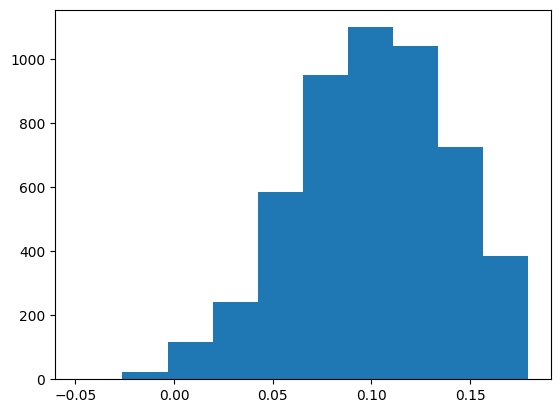

In [535]:
plt.hist(score,bins=10)